In [ ]:
### This program uses 3 diferent machine learning algorithms in order to predict the possible movement of a stock price based on technical analysis.
### The algorithms are the following:
### - Long Short-term Memory
### - ARIMA
### - Neural Networks

### This program creates a Web UI using the library StreamLit
### Please make sure to install all the necesary dependencies

#### Disclamer: Do not take the result of this algorithm as financial advice. Like a wise trader once said "Technical Analysis is Astrology for stock traders"

In [1]:
# ********* Import of required libaries *************
import pandas as pd
import numpy as np
import math
import streamlit as st
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import alpaca_trade_api as tradeapi
from pathlib import Path
import holoviews as hv
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [ ]:
# ARIMA MODEL LOGIC

In [3]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [4]:
# Set the tickers
tickers = ["SPY"]

In [5]:
# Set timeframe to one day ("1Day") for the Alpaca API
timeframe = "1Day"

In [6]:
# Format start and end dates as ISO format for one year period
start = pd.Timestamp("2014-02-14", tz="America/New_York").isoformat()
end = pd.Timestamp("2023-12-14", tz="America/New_York").isoformat()



In [7]:
# Get closing prices for SPY from the last year
df = alpaca.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

# Display sample data
df.head(10)

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,201.0192,201.03,198.59,655489,200.490,225903783,200.656423,SPY
2016-01-05 05:00:00+00:00,201.3600,201.90,200.05,418709,201.405,112719152,201.084280,SPY
2016-01-06 05:00:00+00:00,198.8200,200.06,197.60,548386,198.330,153948196,198.956460,SPY
2016-01-07 05:00:00+00:00,194.0500,197.44,193.59,796451,195.330,216191953,195.345911,SPY
2016-01-08 05:00:00+00:00,191.9230,195.85,191.58,754102,195.190,216105404,193.644537,SPY
2016-01-11 05:00:00+00:00,192.1100,193.41,189.82,701548,193.010,205368067,191.757659,SPY
2016-01-12 05:00:00+00:00,193.6608,194.55,191.14,635749,193.820,175844276,192.902295,SPY
2016-01-13 05:00:00+00:00,188.8300,194.86,188.38,812694,194.450,223632834,191.134590,SPY
2016-01-14 05:00:00+00:00,191.9300,193.26,187.66,824320,189.550,243821116,190.776550,SPY


In [8]:
df = df.drop(columns=['symbol'])

In [9]:
df['signal'] = 0
df

,close,high,low,trade_count,open,volume,vwap,signal
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,201.0192,201.0300,198.59,655489,200.490,225903783,200.656423,0
2016-01-05 05:00:00+00:00,201.3600,201.9000,200.05,418709,201.405,112719152,201.084280,0
2016-01-06 05:00:00+00:00,198.8200,200.0600,197.60,548386,198.330,153948196,198.956460,0
2016-01-07 05:00:00+00:00,194.0500,197.4400,193.59,796451,195.330,216191953,195.345911,0
2016-01-08 05:00:00+00:00,191.9230,195.8500,191.58,754102,195.190,216105404,193.644537,0
...,...,...,...,...,...,...,...,...
2023-12-08 05:00:00+00:00,460.2000,460.7450,457.21,524786,457.460,83124965,459.278999,0
2023-12-11 05:00:00+00:00,461.9900,462.1700,459.47,461247,459.690,65803711,460.936716,0
2023-12-12 05:00:00+00:00,464.1000,464.2000,460.60,438136,461.630,68329617,462.917041,0


In [10]:
# Function to create the signal
def signal_creator_5(row):
    percent_diff = (row['close'] - row['shifted_close_5']) / row['shifted_close_5']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

In [11]:
def signal_creator_15(row):
    percent_diff = (row['close'] - row['shifted_close_15']) / row['shifted_close_15']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

In [12]:
def signal_creator_30(row):
    percent_diff = (row['close'] - row['shifted_close_30']) / row['shifted_close_30']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

In [13]:
# 5 day shift
df['shifted_close_5'] = df['close'].shift(periods=5)
df['signal_5'] = 0
df['signal_5'] = df.apply(signal_creator_5, axis=1)

In [14]:
# 15 day shift
df['shifted_close_15'] = df['close'].shift(periods=15)
df['signal_15'] = 0
df['signal_15'] = df.apply(signal_creator_15, axis=1)

In [15]:
# 30 day shift
df['shifted_close_30'] = df['close'].shift(periods=30)
df['signal_30'] = 0
df['signal_30'] = df.apply(signal_creator_30, axis=1)

In [16]:
# Columns and NA drops to prevent data leakege
df.dropna(inplace=True)
df.drop(columns=['shifted_close_5','shifted_close_15','shifted_close_30'],inplace=True)
display(df.head(50))

,close,high,low,trade_count,open,volume,vwap,signal,signal_5,signal_15,signal_30
timestamp,,,,,,,,,,,
2016-02-17 05:00:00+00:00,192.8800,193.3200,191.0100,531583,191.17,137936059,192.270038,0,1,0,-1
2016-02-18 05:00:00+00:00,192.0900,193.2700,191.7200,459680,193.20,103630950,192.382572,0,1,0,-1
2016-02-19 05:00:00+00:00,192.0000,192.1800,190.4500,424661,191.17,117844861,191.562853,0,1,0,-1
2016-02-22 05:00:00+00:00,194.7800,194.9500,193.7900,360507,193.87,110378274,194.347157,0,1,0,0
2016-02-23 05:00:00+00:00,192.3200,194.3200,192.1800,434602,193.99,112962491,193.064938,0,0,0,0
2016-02-24 05:00:00+00:00,193.2000,193.5300,189.3200,588124,190.63,159573885,191.513613,0,0,0,0
2016-02-25 05:00:00+00:00,195.5400,195.5500,192.8300,417790,193.73,114169518,194.235931,0,0,0,0
2016-02-26 05:00:00+00:00,195.0892,196.6800,194.9000,461021,196.57,133322130,195.672790,0,0,0,1
2016-02-29 05:00:00+00:00,193.3500,196.2300,193.3300,428044,195.11,130754750,194.723359,0,0,0,0


In [17]:
# Separate features and target
features = df.drop(columns = ['signal_5', 'signal_15', 'signal_30'], axis=1)
target = df.drop(columns = ['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
display(target)

,signal,signal_5,signal_15,signal_30
timestamp,,,,
2016-02-17 05:00:00+00:00,0,1,0,-1
2016-02-18 05:00:00+00:00,0,1,0,-1
2016-02-19 05:00:00+00:00,0,1,0,-1
2016-02-22 05:00:00+00:00,0,1,0,0
2016-02-23 05:00:00+00:00,0,0,0,0
...,...,...,...,...
2023-12-08 05:00:00+00:00,0,0,0,1
2023-12-11 05:00:00+00:00,0,0,0,1
2023-12-12 05:00:00+00:00,0,0,0,1


In [18]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# # Fit the ARIMA model
# # Replace p, d, q with your chosen values
# p = 5
# d = 1
# q = 0

# model = ARIMA(df['close'], order=(p, d, q))
# model_fit = model.fit()

# # Forecasting
# forecast = model_fit.forecast(steps=5)

# # Display the forecast
# print(forecast)


C:\Users\marco\AppData\Local\Temp\ipykernel_23624\3798745839.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  series.index = pd.to_datetime(series.index).to_period('D')


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1972
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5403.036
Date:                Thu, 14 Dec 2023   AIC                          10818.073
Time:                        16:25:30   BIC                          10851.591
Sample:                    02-17-2016   HQIC                         10830.389
                         - 12-14-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0664      0.014     -4.805      0.000      -0.094      -0.039
ar.L2          0.0474      0.012      3.862      0.000       0.023       0.071
ar.L3         -0.0163      0.013     -1.247      0.2

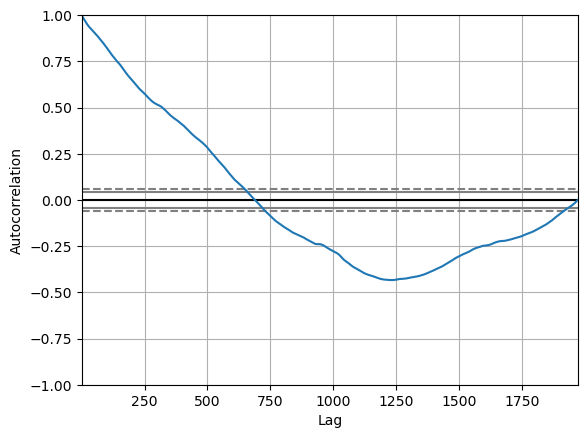

In [19]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# # Fetching data from Alpaca (example for 'SPY')
# symbol = "SPY"
# start_date = "2014-02-07"
# end_date = "2020-02-07"
# timeframe = tradeapi.TimeFrame.Day

# df = alpaca.get_bars(symbol, timeframe, start_date, end_date).df

# Use 'close' prices for ARIMA
series = df['close']

# Convert the index to a PeriodIndex for daily frequency
series.index = pd.to_datetime(series.index).to_period('D')

# Fit the ARIMA model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# Summary of the fitted model
print(model_fit.summary())

# Check index type and plot autocorrelation
print("Index type before conversion:", type(series.index))
autocorrelation_plot(series)
pyplot.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# def ArimaModel(model):

# Split the DataFrame into training and testing sets (90% train, 10% test)
train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# Prepare the training and testing data (using 'close' prices)
train_arima = train_data['close']
test_arima = test_data['close']

# Initialize history with the training data
history = [x for x in train_arima]
# Prepare a list to store the forecasts
predictions = []

# Loop over the test data
for t in range(len(test_arima)):
    # Fit the ARIMA model
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()

    # Forecast the next value
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # Add the actual observation to history for the next loop
    history.append(test_arima.iloc[t])


In [32]:
print(history)

[192.88, 192.09, 192.0, 194.78, 192.32, 193.2, 195.54, 195.0892, 193.35, 198.11, 199.0, 199.775, 200.43, 200.59, 198.4, 199.38, 199.54, 202.76, 202.5, 202.17, 203.34, 204.63, 204.38, 204.67, 204.56, 203.2092, 203.12, 203.24, 205.1208, 206.02, 205.52, 206.92, 206.25, 204.19, 206.42, 203.95, 204.4992, 204.0201, 205.92, 208.0008, 208.01, 207.78, 209.2392, 209.9, 210.1, 208.97, 208.97, 208.61, 208.9192, 209.35, 207.4475, 206.3308, 207.97, 206.1592, 205.01, 204.97, 205.72, 205.8892, 208.45, 206.5, 206.56, 204.76, 206.78, 204.8508, 204.91, 204.2, 205.49, 205.21, 207.87, 209.28, 209.34, 210.24, 209.84, 210.27, 210.91, 210.28, 211.35, 211.68, 212.37, 212.08, 210.07, 208.4492, 208.04, 207.75, 208.37, 206.52, 207.85, 208.44, 208.1, 210.81, 203.2425, 199.6, 203.1997, 206.66, 209.475, 209.9208, 208.41, 209.66, 209.526, 212.65, 213.4, 214.95, 214.92, 216.12, 215.83, 216.4092, 216.19, 217.085, 216.265, 217.24, 216.65, 216.75, 216.52, 216.77, 217.12, 216.94, 215.5492, 216.18, 216.4097, 218.18, 218.05

In [21]:
yhat

470.17713989030585

In [22]:
# report performance
mse = mean_squared_error(test_arima, predictions)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_arima, predictions)
print('MAE: ' + str(mae))

rmse = math.sqrt(mse)
print('RMSE: ' + str(rmse))

MSE: 11.677013742764105
MAE: 2.7011834009570492
RMSE: 3.417164576482102


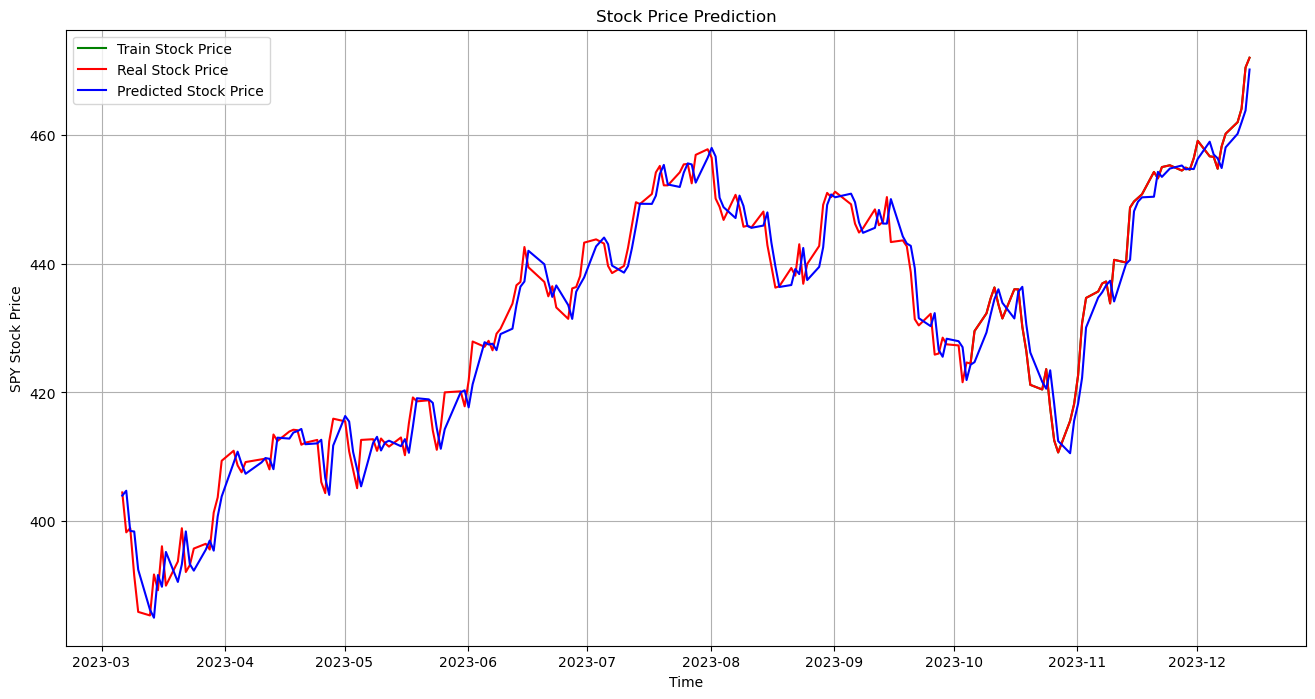

In [33]:
# Plot the predictions
plt.figure(figsize=(16,8))
plt.plot(df.index[-50:], df['close'].tail(50), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_arima, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()



In [ ]:
# If we analize the resulting graph, we can apreciate that the resulting prediction for the ARIMA model is laging behind the actual stock price, which can result
# in a delayed signal generation, therefore creating a relative risk in the signals.

In [24]:
# Function to interpret predictions
def interpret_prediction(prediction):
    percent_difference = (prediction['close'] - prediction['predicted']) / prediction['predicted']
    if percent_difference > 0.03:
        return 1  # Buy
    elif percent_difference < -0.03:
        return -1  # Sell
    else:
        return 0  # Hold

In [ ]:
# NEURAL NETWORKS MODEL LOGIC

In [ ]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [ ]:
# Set ticker
tickers = ["JPM"]

In [ ]:
# Set timeframe
timeframe = "1Day"

In [ ]:
# Format start and end dates as ISO format for one year period
start = pd.Timestamp("2014-02-07", tz="America/New_York").isoformat()
end = pd.Timestamp("2020-02-07", tz="America/New_York").isoformat()

In [ ]:
# Get closing prices for stock from the last year
df = alpaca.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

def signal_creator_5(row):
    percent_diff = (row['close'] - row['shifted_close_5']) / row['shifted_close_5']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0
    
def signal_creator_15(row):
    percent_diff = (row['close'] - row['shifted_close_15']) / row['shifted_close_15']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

def signal_creator_30(row):
    percent_diff = (row['close'] - row['shifted_close_30']) / row['shifted_close_30']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

df = df.drop(columns=['symbol'])

# 5 day shift
df['shifted_close_5'] = df['close'].shift(periods=5)
df['signal_5'] = 0
print(df)
df['signal_5'] = df.apply(signal_creator_5, axis=1)

# 15 day shift
df['shifted_close_15'] = df['close'].shift(periods=15)
df['signal_15'] = 0
print(df)
df['signal_15'] = df.apply(signal_creator_15, axis=1)

# 30 day shift
df['shifted_close_30'] = df['close'].shift(periods=30)
df['signal_30'] = 0
df['signal_30'] = df.apply(signal_creator_30, axis=1)

# Columns and NA drops to prevent data leakege
df.dropna(inplace=True)
df.drop(columns=['shifted_close_5','shifted_close_15','shifted_close_30'],inplace=True)

# Display sample data
df.tail(10)

In [ ]:
# Use adjusted close prices to predict future

df = alpaca.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

data = df['close'].values.reshape(-1, 1)

In [ ]:
# Scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
def prepare_data(data, n_steps, n_days):
    X, y = [], []
    for i in range(len(data) - n_steps - n_days):
        X.append(data[i : i + n_steps, 0])
        y.append(data[i + n_steps : i + n_steps + n_days, 0])
    return np.array(X), np.array(y)

# Update for 5 days model
n_steps_5 = 5
n_days_5 = 5  

# Define and compile the model for 5 day prediction
model_5 = Sequential()
model_5.add(LSTM(units=50, activation='relu', input_shape=(n_steps_5, 1)))
model_5.add(Dense(units=n_days_5))
model_5.compile(optimizer='adam', loss='mse')

# Prepare the data for 5 day prediction
X_5, y_5 = prepare_data(data_scaled, n_steps_5, n_days_5)
X_5 = X_5.reshape((X_5.shape[0], X_5.shape[1], 1))

# Fit the model for 5-day prediction
model_5.fit(X_5, y_5, epochs=50, verbose=1)

# Update for 10 days model
n_steps_10 = 10
n_days_10 = 10 

# Define and compile the model for 10 day prediction
model_10 = Sequential()
model_10.add(LSTM(units=50, activation='relu', input_shape=(n_steps_10, 1)))
model_10.add(Dense(units=n_days_10))
model_10.compile(optimizer='adam', loss='mse')

# Prepare the data for 10 day prediction
X_10, y_10 = prepare_data(data_scaled, n_steps_10, n_days_10)
X_10 = X_10.reshape((X_10.shape[0], X_10.shape[1], 1))

# Fit the model for 10 day prediction
model_10.fit(X_10, y_10, epochs=50, verbose=1)

# Update for 30 days model
n_steps_30 = 30
n_days_30 = 30 

# Define and compile the model for 30 day prediction
model_30 = Sequential()
model_30.add(LSTM(units=50, activation='relu', input_shape=(n_steps_30, 1)))
model_30.add(Dense(units=n_days_30))
model_30.compile(optimizer='adam', loss='mse')

# Prepare the data for 30 day prediction
X_30, y_30 = prepare_data(data_scaled, n_steps_30, n_days_30)
X_30 = X_30.reshape((X_30.shape[0], X_30.shape[1], 1))

# Fit the model for 30 day prediction
model_30.fit(X_30, y_30, epochs=50, verbose=1)

In [ ]:
# Prepare and reshape data

# Define parameters for each model
n_steps_5 = 5
n_days_5 = 5

n_steps_10 = 10
n_days_10 = 10

n_steps_30 = 30
n_days_30 = 30

# Prepare and reshape data for 5 day model
X_test_5, _ = prepare_data(data_scaled, n_steps_5, n_days_5)
X_test_5 = X_test_5.reshape((X_test_5.shape[0], X_test_5.shape[1], 1))

# Prepare and reshape data for 10 day model
X_test_10, _ = prepare_data(data_scaled, n_steps_10, n_days_10)
X_test_10 = X_test_10.reshape((X_test_10.shape[0], X_test_10.shape[1], 1))

# Prepare and reshape data for 30 day model
X_test_30, _ = prepare_data(data_scaled, n_steps_30, n_days_30)
X_test_30 = X_test_30.reshape((X_test_30.shape[0], X_test_30.shape[1], 1))

# Generate predictions
predictions_5 = model_5.predict(X_test_5)
predictions_10 = model_10.predict(X_test_10)
predictions_30 = model_30.predict(X_test_30)

# Inverse transform the scaled predictions for stock prices
predictions_5 = scaler.inverse_transform(predictions_5)
predictions_10 = scaler.inverse_transform(predictions_10)
predictions_30 = scaler.inverse_transform(predictions_30)

In [ ]:
# Set title and data
print("Predicted Prices for the Next 5 Days:")
print(predictions_5)

# Plot
plt.plot(predictions_5[1020], label="Predicted Prices")
plt.title("Predicted Prices for the Next 5 Days")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# Set title and data
print("Predicted Prices for the Next 10 Days:")
print(predictions_10)

# Plot
plt.plot(predictions_10[1011], label="Predicted Prices")
plt.title("Predicted Prices for the Next 10 Days")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
# Set title and data
print("Predicted Prices for the Next 30 Days:")
print(predictions_30)

# Plot
plt.plot(predictions_30[971], label="Predicted Prices")
plt.title("Predicted Prices for the Next 30 Days")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
# The resulting graphs are results of the model predictions of the price of the selected stock over a 5, 10 and 30 days period

In [ ]:
# LSTM MODEL LOGIC (For sake of simplicity we will just present here the 5 days set, the other 2 models can be seen in the .py file)

In [ ]:
# Create the Alpaca API object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

In [ ]:
# Set the tickers and timeframe
tickers = ["TSLA"]
timeframe = "1Day"

# Set the date range
today = pd.Timestamp.today(tz="America/New_York").normalize().isoformat()

start = pd.Timestamp("2000-02-07", tz="America/New_York").isoformat()
end = pd.Timestamp("2023-12-13", tz="America/New_York").isoformat()

# Get the data
df = alpaca.get_bars(tickers, timeframe, start=start, end=end).df

# Drop the 'symbol' column and add shifted close column
df = df.drop(columns=['symbol'])

# Function to create the signal
def signal_creator_5(row):
    percent_diff = (row['close'] - row['shifted_close_5']) / row['shifted_close_5']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

def signal_creator_15(row):
    percent_diff = (row['close'] - row['shifted_close_15']) / row['shifted_close_15']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

def signal_creator_30(row):
    percent_diff = (row['close'] - row['shifted_close_30']) / row['shifted_close_30']
    if percent_diff > 0.03:
        return 1
    elif percent_diff < -0.03:
        return -1
    else:
        return 0

# 5 day shift
df['shifted_close_5'] = df['close'].shift(periods=5)
df['signal_5'] = 0
df['signal_5'] = df.apply(signal_creator_5, axis=1)

# 15 day shift
df['shifted_close_15'] = df['close'].shift(periods=15)
df['signal_15'] = 0
df['signal_15'] = df.apply(signal_creator_15, axis=1)

# 30 day shift
df['shifted_close_30'] = df['close'].shift(periods=30)
df['signal_30'] = 0
df['signal_30'] = df.apply(signal_creator_30, axis=1)

# Columns and NA drops to prevent data leakege
display(df.tail(10))

In [ ]:
df.dropna(inplace=True)
df.drop(columns=['shifted_close_5','shifted_close_15','shifted_close_30'],inplace=True)
display(df.tail(50))

# Separate features and target
features = df.drop(columns = ['signal_5', 'signal_15', 'signal_30'], axis=1)
target = df.drop(columns = ['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap','signal_15', 'signal_30'], axis=1)
display(target)

In [ ]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
# Function to create dataset for LSTM
def create_dataset(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
# Creating the dataset
time_steps = 5
X, y = create_dataset(scaled_features, target.values, time_steps)

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=13)

In [ ]:
model_5 = Sequential()

In [ ]:
# model_15 = Sequential()

In [ ]:
# model_30 = Sequential()

In [ ]:
# Building the LSTM model
def builder(model):
  model.add(LSTM(150, return_sequences=True, input_shape=(time_steps, X.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(75, return_sequences=False))
  model.add(Dense(50,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(25,activation='relu'))
  model.add(Dense(1,activation='linear'))

In [ ]:
builder(model_5)

In [ ]:
# builder(model_15)

In [ ]:
# builder(model_30)

In [ ]:
# Compiling the model
model_5.compile(optimizer='adam', loss='mean_squared_error')
# model_15.compile(optimizer='adam', loss='mean_squared_error')
# model_30.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Training the model
model_5.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
# model_15.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
# model_30.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
# Model Evaluation
def eval(model):
  test_loss = model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss}')

In [ ]:
eval(model_5)

In [ ]:
# eval(model_15)
aplication_size = int(len(X)*0.9) # 20% of the data

X_train_app, X_test_app = X[:aplication_size], X[aplication_size:]
y_train_app, y_test_app = y[:aplication_size], y[aplication_size:]

In [ ]:
# Making Predictions
predictions_5 = model_5.predict(X_test_app)
print(predictions_5)

In [ ]:
for x in predictions_5:
    if x < -0.3:
        print(x)

In [ ]:
# predictions_15 = model_15.predict(X_test)
# print(confusion_matrix(y_test, predictions_5))
y_test_app

In [ ]:
# predictions_30 = model_30.predict(X_test)

In [ ]:
# Function to interpret predictions
def interpret_prediction(prediction):
    if prediction > 0.3:
        return 1  # Buy
    elif prediction < -0.3:
        return -1  # Sell
    else:
        return 0  # Hold

In [ ]:
# results_5 = [interpret_prediction(p[0]) for p in predictions_5]
# print(results_5[:1])
pred_result = [interpret_prediction(p[0]) for p in predictions_5]
confusion_matrix(y_test_app, pred_result)

In [ ]:
# results_5 = [interpret_prediction(p[0]) for p in predictions_5]
# print(results_5[:1])
pred_result = [interpret_prediction(p[0]) for p in predictions_5]
confusion_matrix(y_test_app, pred_result)

In [ ]:
# results_15 = [interpret_prediction(p[0]) for p in predictions_15]
# print(results_15[:-25])
print(classification_report(y_test_app, pred_result))

In [ ]:
# results_30 = [interpret_prediction(p[0]) for p in predictions_30]
# print(results_30[:-25])
pred_result[-1]

In [ ]:
# If we change the parameters of the prediction in the function "interpret_prediction(prediction)", we variate the levels of precision
# of the model for the specific stock. Therefore, this model has to be optimized for every stock specifically because otherwise would loose most of
# his benefits if is generalized